<a href="https://colab.research.google.com/github/beyzassevval/beyzassevval/blob/main/zor_%C3%B6rnek_deneme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Temel kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Veri ön işleme
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Makine öğrenmesi modelleri
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Model değerlendirme
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Uyarıları gizleme
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Kaggle'dan veri setini indirme
import kagglehub
path = kagglehub.dataset_download('prasad22/healthcare-dataset')
print(f"Dataset path: {path}")

# CSV dosyasını bulma ve okuma
import os
for file in os.listdir(path):
    if file.endswith('.csv'):
        csv_path = os.path.join(path, file)
        print(f"Found CSV file: {csv_path}")
        df = pd.read_csv(csv_path)
        break

# İlk 5 satırı görüntüleme
print("\nVeri seti önizleme:")
display(df.head())
print(f"\nVeri seti boyutu: {df.shape}")

Dataset path: /kaggle/input/healthcare-dataset
Found CSV file: /kaggle/input/healthcare-dataset/healthcare_dataset.csv

Veri seti önizleme:


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal



Veri seti boyutu: (55500, 15)


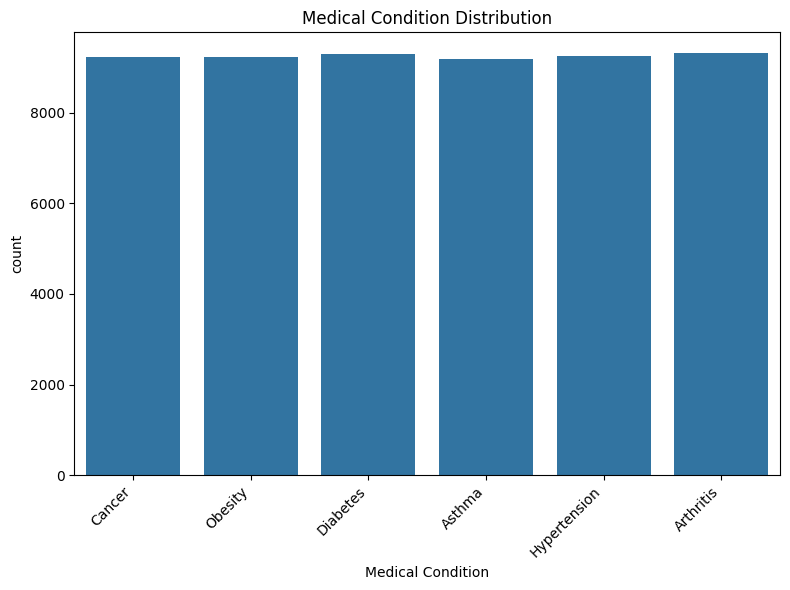

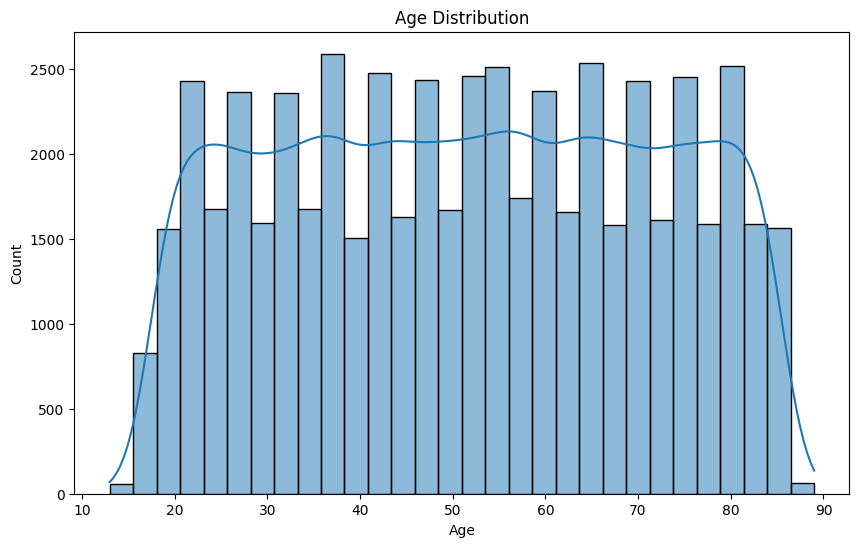

In [ ]:
# Grafik 1: Hedef değişken dağılımı
plt.figure(figsize=(8, 6))
sns.countplot(x='Medical Condition', data=df) # Changed 'HeartDisease' to 'Medical Condition'
plt.title('Medical Condition Distribution') # Changed title
plt.xticks(rotation=45, ha='right') # Added rotation for better readability of x-axis labels
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# Grafik 2: Yaş dağılımı
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Age Distribution') # Changed title
plt.xlabel('Age') # Changed xlabel
plt.show()

# Grafik 3: Kolesterol ve Maksimum Kalp Atışı İlişkisi - NOTE: Cholesterol and MaxHR columns are not present in the current dataframe. Skipping this plot.
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Cholesterol', y='MaxHR', hue='Medical Condition', data=df, alpha=0.7) # Changed hue
# plt.title('Cholesterol vs Maximum Heart Rate') # Changed title
# plt.show()

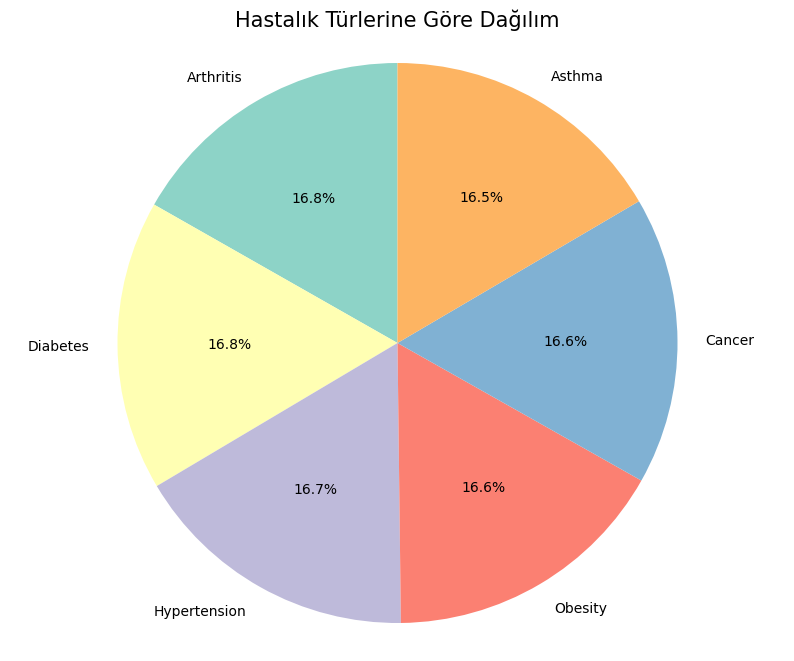

In [ ]:
# Hastalık türlerine göre sayım
disease_counts = df['Medical Condition'].value_counts()

plt.figure(figsize=(10, 8))
plt.pie(disease_counts, labels=disease_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette('Set3'))
plt.title('Hastalık Türlerine Göre Dağılım', fontsize=15)
plt.axis('equal')  # Daireyi düzgün göstermek için
plt.show()

In [ ]:
# Kategorik değişkenleri dönüştürme
from sklearn.preprocessing import LabelEncoder

cat_cols = df.select_dtypes(include=['object']).columns

# Convert 'Date of Admission' and 'Discharge Date' to numeric (e.g., days since a reference date)
# or drop them if not needed for the current analysis.
# For simplicity, let's drop them for now if they are still objects after Label Encoding.
date_cols = ['Date of Admission', 'Discharge Date']
for col in cat_cols:
    if col not in date_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    else:
      # Attempt to convert to datetime and then to a numerical representation (e.g., ordinal)
      # If conversion fails, drop the column
      try:
        df[col] = pd.to_datetime(df[col]).apply(lambda x: x.toordinal())
      except:
        df = df.drop(col, axis=1)
        print(f"Dropped column '{col}' due to conversion errors.")


# Eksik değer kontrolü ve doldurma
print("\nEksik değerler:")
print(df.isnull().sum())

# Basit doldurma işlemi - using mean for numerical data after label encoding
df.fillna(df.mean(numeric_only=True), inplace=True)


# Bağımlı ve bağımsız değişkenleri ayırma
# Based on previous plots, 'Medical Condition' is likely the target variable
X = df.drop('Medical Condition', axis=1)
y = df['Medical Condition']

# Eğitim ve test seti
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Eksik değerler:
Name                  0
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Date of Admission     0
Doctor                0
Hospital              0
Insurance Provider    0
Billing Amount        0
Room Number           0
Admission Type        0
Discharge Date        0
Medication            0
Test Results          0
dtype: int64


In [ ]:
# Aykırı değer işleme
def handle_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.clip(df[col], lower_bound, upper_bound)
    return df

# Sayısal sütunlarda aykırı değerleri düzeltme
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns # Apply to X_train and X_test separately
X_train = handle_outliers(X_train, numeric_cols)
X_test = handle_outliers(X_test, numeric_cols)

# Kategorik değişken kodlama - Label Encoding yerine One-Hot Encoding
# Combine train and test for one-hot encoding to ensure consistent columns
combined_X = pd.concat([X_train, X_test], ignore_index=True)
combined_X = pd.get_dummies(combined_X, drop_first=True)

# Split back into train and test
X_train = combined_X.iloc[:len(X_train)]
X_test = combined_X.iloc[len(X_train):]

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# PCA öncesi SMOTE uygulama
X_train_pca = pca.fit_transform(X_resampled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
from sklearn.model_selection import GridSearchCV
# Ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE ile örneklem dengesizliğini giderme
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# PCA ile boyut azaltma
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_resampled)
X_test_pca = pca.transform(X_test_scaled)

print("PCA Sonrası Eğitim Verisi Boyutu:", X_train_pca.shape)
print("PCA Sonrası Test Verisi Boyutu:", X_test_pca.shape)

PCA Sonrası Eğitim Verisi Boyutu: (44892, 13)
PCA Sonrası Test Verisi Boyutu: (11100, 13)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import time

start_time = time.time()

# Basitleştirilmiş parametre gridi
knn_params = {
    'n_neighbors': [3, 5, 7],  # Daha az seçenek
    'weights': ['distance'],    # Sadece daha iyi performans veren
    'metric': ['euclidean']     # En yaygın olan
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=knn_params,
    cv=3,                      # Daha az çapraz doğrulama
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

knn_grid.fit(X_train_pca[:2000], y_resampled[:2000])  # Örnek sayısını azalt

print(f"Süre: {(time.time()-start_time)/60:.1f} dakika")
print("En iyi parametreler:", knn_grid.best_params_)
best_knn = knn_grid.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Süre: 0.1 dakika
En iyi parametreler: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


In [ ]:
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()

# Daha küçük parametre gridi
rf_params = {
    'n_estimators': [100, 200],  # Daha az ağaç sayısı
    'max_depth': [10, 20],       # Sınırlı derinlik
    'min_samples_split': [2, 5]  # Temel değerler
}

rf_grid = GridSearchCV(
    RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    param_grid=rf_params,
    cv=3,                       # Daha az çapraz doğrulama
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_pca[:3000], y_resampled[:3000])  # Örnek sayısını azalt

print(f"Süre: {(time.time()-start_time)/60:.1f} dakika")
print("En iyi parametreler:", rf_grid.best_params_)
best_rf = rf_grid.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Süre: 0.6 dakika
En iyi parametreler: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}


In [ ]:
# LightGBM gibi daha hızlı algoritmalar
from lightgbm import LGBMClassifier

lgbm_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1]
}

lgbm_grid = GridSearchCV(
    LGBMClassifier(),
    param_grid=lgbm_params,
    cv=3,
    n_jobs=-1
)

In [ ]:
start_time = time.time()

lgbm_grid.fit(X_train_pca, y_resampled)

print(f"Süre: {(time.time()-start_time)/60:.1f} dakika")
print("En iyi parametreler:", lgbm_grid.best_params_)
best_LGBMClassifier = lgbm_grid.best_estimator_

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 44892, number of used features: 13
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
Süre: 0.5 dakika
En iyi parametreler: {'learning_rate': 0.1, 'n_estimators': 100}


In [ ]:
# Optimize edilmiş modelleri dictionary'de topla
optimized_models = {
    "Optimized_KNN": best_knn,
    "Optimized_LGBMClassifier": best_LGBMClassifier,
    "Optimized_RandomForest": best_rf
}

# Model isimlerini ve parametrelerini görüntüle
print("\nOptimize Edilmiş Modeller:")
for name, model in optimized_models.items():
    print(f"\n{name}:")
    print(model)


Optimize Edilmiş Modeller:

Optimized_KNN:
KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')

Optimized_LGBMClassifier:
LGBMClassifier()

Optimized_RandomForest:
RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_split=5, n_jobs=-1, random_state=42)



--------------------------------------------------
Optimized_KNN Performansı:
Accuracy: 0.1752

Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.17      0.18      1915
           1       0.16      0.15      0.16      1847
           2       0.17      0.18      0.17      1871
           3       0.19      0.20      0.19      1822
           4       0.16      0.16      0.16      1788
           5       0.19      0.19      0.19      1857

    accuracy                           0.18     11100
   macro avg       0.17      0.18      0.17     11100
weighted avg       0.18      0.18      0.17     11100



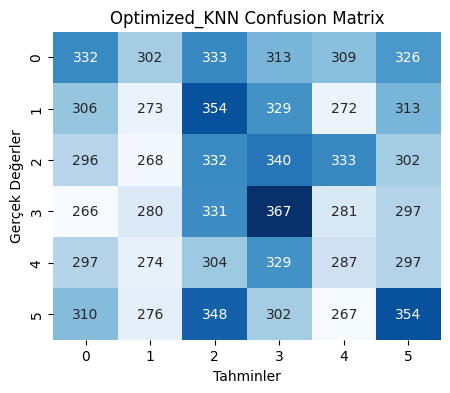


--------------------------------------------------
Optimized_LGBMClassifier Performansı:
Accuracy: 0.2116

Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.20      0.21      1915
           1       0.21      0.20      0.21      1847
           2       0.21      0.22      0.22      1871
           3       0.21      0.22      0.21      1822
           4       0.21      0.22      0.21      1788
           5       0.21      0.22      0.21      1857

    accuracy                           0.21     11100
   macro avg       0.21      0.21      0.21     11100
weighted avg       0.21      0.21      0.21     11100



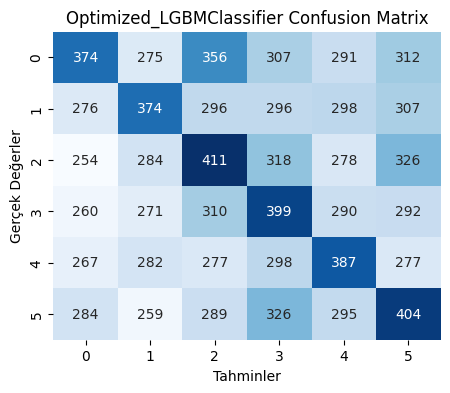


--------------------------------------------------
Optimized_RandomForest Performansı:
Accuracy: 0.1719

Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.19      0.19      1915
           1       0.16      0.17      0.17      1847
           2       0.16      0.18      0.17      1871
           3       0.17      0.19      0.18      1822
           4       0.18      0.14      0.16      1788
           5       0.17      0.16      0.17      1857

    accuracy                           0.17     11100
   macro avg       0.17      0.17      0.17     11100
weighted avg       0.17      0.17      0.17     11100



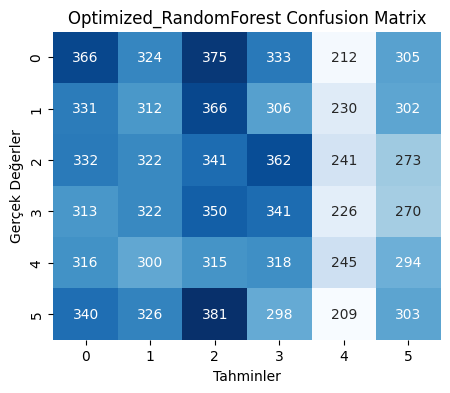


EN İYİ MODEL: Optimized_LGBMClassifier
Doğruluk: 0.2116


In [ ]:
# Optimize modellerin test seti üzerinde değerlendirilmesi
results = {}

for name, model in optimized_models.items():
    # Tahmin yap
    y_pred = model.predict(X_test_pca)

    # Metrikleri hesapla
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    # Sonuçları yazdır
    print(f"\n{'-'*50}")
    print(f"{name} Performansı:")
    print(f"Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix çiz
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True,
                fmt='d',
                cmap='Blues',
                cbar=False)
    plt.title(f"{name} Confusion Matrix")
    plt.ylabel('Gerçek Değerler')
    plt.xlabel('Tahminler')
    plt.show()

# En iyi modeli seç
best_model_name = max(results, key=results.get)
print(f"\n{'='*50}")
print(f"EN İYİ MODEL: {best_model_name}")
print(f"Doğruluk: {results[best_model_name]:.4f}")
print(f"{'='*50}")

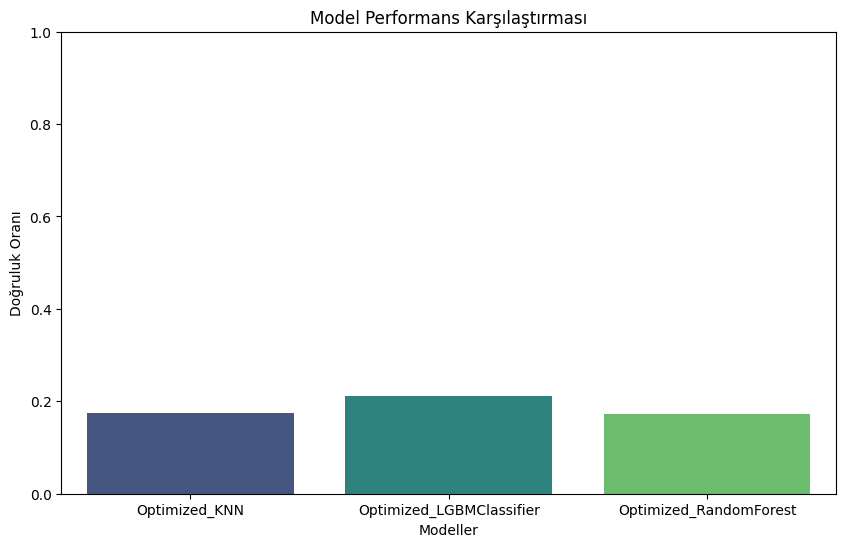

En iyi performans gösteren model: Optimized_LGBMClassifier (%21.16 doğruluk)


In [ ]:
# Model performans karşılaştırması
plt.figure(figsize=(10, 6))
model_names = list(results.keys())
acc_values = list(results.values())
sns.barplot(x=model_names, y=acc_values, palette="viridis")
plt.ylim(0, 1)
plt.title('Model Performans Karşılaştırması')
plt.ylabel('Doğruluk Oranı')
plt.xlabel('Modeller')
plt.show()

# En iyi modeli seçme
best_model = max(results, key=results.get)
print(f"En iyi performans gösteren model: {best_model} (%{results[best_model]*100:.2f} doğruluk)")